In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive/data/

/content/drive/MyDrive/data


In [ ]:
!pip install tsfresh

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import random
import math
from tsfresh.feature_extraction import extract_features, ComprehensiveFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [2]:

event_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Hydrate in Production Line'
               }

fc_parameters = {
    "mean": None,
    "median": None,
    "variance": None,
    "skewness": None,
    "kurtosis": None,
    "fft_aggregated": [{'aggtype': 'centroid'}, {'aggtype': 'variance'}, {'aggtype': 'skew'}, {'aggtype': 'kurtosis'}],
    "maximum": None,
    "minimum": None,
    "quantile": [{'q': 0.1}, {'q': 0.2}, {'q': 0.3}, {'q': 0.4}, {'q': 0.6}, {'q': 0.7}, {'q': 0.8}, {'q': 0.9}],
    "variation_coefficient": None,
    "mean_change": None,
    "mean_second_derivative_central": None,
    "friedrich_coefficients": [{'coeff': 1, 'm': 1, 'r': 30}, {'coeff': 1, 'm': 3, 'r': 30}],
}

standard_scaler = preprocessing.StandardScaler()
minmax_scaler = preprocessing.MinMaxScaler()


Delete rows without a class

In [ ]:
for f in range(0, 9):
  path_dir = str(f)
  os.mkdir(path_dir + path_dir)
  for file in os.listdir(path_dir):
    df = pd.read_csv(path_dir + "/" + file)
    df = df[df['class'].notna()]
    df.to_csv(path_dir + path_dir + "/" + file, index=False)

### Downsampling

10 sec

In [ ]:
for f in range(0, 9):
  str_f = str(f)
  path_dir = str_f + str_f
  os.mkdir(f"downsampled/{str_f}")
  for file in os.listdir(path_dir):
    df = pd.read_csv(path_dir + "/" + file)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.resample('10S', on='timestamp').mean()
    df.to_csv(f"downsampled/{str_f}/{file}", index=False)

20 sec\
Pošto sam ja već u prvom dijelu radio 10s downsamplanje, možemo sad na 20

In [ ]:
for f in range(0, 9):
  str_f = str(f)
  path_dir = str_f + str_f
  os.mkdir(f"downsampled20/{str_f}")
  for file in os.listdir(path_dir):
    df = pd.read_csv(path_dir + "/" + file)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.resample('20S', on='timestamp').mean()
    df.to_csv(f"downsampled20/{str_f}/{file}", index=False)

### Time window division

In [ ]:
os.mkdir("divided300")

### hiperparameter
time_window_size = 30

for f in range(0, 9):
  if f == 7:
    continue
  path_dir = str(f)
  os.mkdir(f"divided300/{f}")
  for file in os.listdir(f"downsampled/{f}"):
    if file.startswith('DRAWN'):
      continue
    df = pd.read_csv(f"downsampled/{path_dir}/{file}")
    df.drop(columns=['P-JUS-CKGL', 'T-JUS-CKGL', 'QGL'], inplace=True)
    df['id'] = 0
    row_count = len(df.index)
    ts_count = 1
    i = 0
    while i < row_count:
      if i + time_window_size < row_count:
        if df['class'].iloc[i] != df['class'].iloc[i+time_window_size]:
          tmp = df.loc[i:(i+time_window_size)]
          maxi = tmp[['class']].value_counts().index[0]
          tmp.loc[df['class'] == maxi, 'id'] = ts_count
          df.loc[i:(i+time_window_size), :] = tmp[:]
        else:
          df.loc[i:(i+time_window_size), 'id'] = ts_count
      elif row_count - i >= time_window_size / 2:
        df.loc[i:(row_count-1), 'id'] = ts_count
      else:
        break
      i += time_window_size
      ts_count += 1

    df.to_csv(f"divided300/{path_dir}/{file}", index=False)


In [ ]:
os.mkdir("divided600")

### hiperparameter
time_window_size = 60

for f in range(0, 9):
  if f == 7:
    continue
  path_dir = str(f)
  os.mkdir(f"divided600/{f}")
  for file in os.listdir(f"downsampled/{f}"):
    if file.startswith('DRAWN'):
      continue
    df = pd.read_csv(f"downsampled/{path_dir}/{file}")
    df.drop(columns=['P-JUS-CKGL', 'T-JUS-CKGL', 'QGL'], inplace=True)
    df['id'] = 0
    row_count = len(df.index)
    ts_count = 1
    i = 0
    while i < row_count:
      if i + time_window_size < row_count:
        if df['class'].iloc[i] != df['class'].iloc[i+time_window_size]:
          tmp = df.loc[i:(i+time_window_size)]
          maxi = tmp[['class']].value_counts().index[0]
          tmp.loc[df['class'] == maxi, 'id'] = ts_count
          df.loc[i:(i+time_window_size), :] = tmp[:]
        else:
          df.loc[i:(i+time_window_size), 'id'] = ts_count
      elif row_count - i >= time_window_size / 2:
        df.loc[i:(row_count-1), 'id'] = ts_count
      else:
        break
      i += time_window_size
      ts_count += 1

    df.to_csv(f"divided600/{path_dir}/{file}", index=False)

In [ ]:
os.mkdir("divided900")

### hiperparameter
time_window_size = 90

for f in range(0, 9):
  if f == 7:
    continue
  path_dir = str(f)
  os.mkdir(f"divided900/{f}")
  for file in os.listdir(f"downsampled/{f}"):
    if file.startswith('DRAWN'):
      continue
    df = pd.read_csv(f"downsampled/{path_dir}/{file}")
    df.drop(columns=['P-JUS-CKGL', 'T-JUS-CKGL', 'QGL'], inplace=True)
    df['id'] = 0
    row_count = len(df.index)
    ts_count = 1
    i = 0
    while i < row_count:
      if i + time_window_size < row_count:
        if df['class'].iloc[i] != df['class'].iloc[i+time_window_size]:
          tmp = df.loc[i:(i+time_window_size)]
          maxi = tmp[['class']].value_counts().index[0]
          tmp.loc[df['class'] == maxi, 'id'] = ts_count
          df.loc[i:(i+time_window_size), :] = tmp[:]
        else:
          df.loc[i:(i+time_window_size), 'id'] = ts_count
      elif row_count - i >= time_window_size / 2:
        df.loc[i:(row_count-1), 'id'] = ts_count
      else:
        break
      i += time_window_size
      ts_count += 1

    df.to_csv(f"divided900/{path_dir}/{file}", index=False)

delete rows with id 0

In [ ]:
l = [30, 60, 90]

for s in l:
  os.mkdir(f"final{s}0")

  for f in range(0, 9):
    if f == 7:
      continue
    path_dir = str(f)
    os.mkdir(f"final{s}0/{path_dir}")
    for file in os.listdir(f"divided{s}0/{path_dir}"):
        df = pd.read_csv(f"divided{s}0/{path_dir}/{file}")
        df = df[df.id != 0]
        df.to_csv(f"final{s}0/{path_dir}/{file}", index=False)

### Feature extraction

In [ ]:
l = [30, 60, 90]


for s in l:
  os.mkdir(f"features{s}0")

  for f in range(0, 9):
    if f == 7:
      continue
    path_dir = str(f)
    os.mkdir(f"features{s}0/{path_dir}")
    for file in os.listdir(f"final{s}0/{path_dir}"):
        df = pd.read_csv(f"final{s}0/{path_dir}/{file}")
        try:
          df = impute(df)
          new_df = extract_features(df, column_id="id", default_fc_parameters=fc_parameters, disable_progressbar=True)
          new_df.to_csv(f"features{s}0/{path_dir}/{file}", index=False)
        except ZeroDivisionError:
          print(file)

### Feature extraction finalization
** everything from now on was done only for 300 seconds time window due to lack of time to execute complex functions, but the procedure is completely same for 600 and 900 seconds time windows

In [ ]:
l = [300]

for s in l:
  os.mkdir(f"final_features{s}")

  for f in range(0, 9):
    if f == 7:
      continue
    path_dir = str(f)
    os.mkdir(f"final_features{s}/{path_dir}")
    for file in os.listdir(f"features{s}/{path_dir}"):
        df = pd.read_csv(f"features{s}/{path_dir}/{file}")
        df = df.rename(columns={'class__mean': 'table_class'})
        cols = [c for c in df.columns if not c.lower().startswith('class')]
        df=df[cols]
        df['class'] = f
        df.to_csv(f"final_features{s}/{path_dir}/{file}", index=False)

# random file just to make sure it looks right
df = pd.read_csv("final_features300/1/SIMULATED_00009.csv")
df.tail()

,P-PDG__mean,P-PDG__median,P-PDG__variance,P-PDG__skewness,P-PDG__kurtosis,"P-PDG__fft_aggregated__aggtype_""centroid""","P-PDG__fft_aggregated__aggtype_""variance""","P-PDG__fft_aggregated__aggtype_""skew""","P-PDG__fft_aggregated__aggtype_""kurtosis""",P-PDG__maximum,P-PDG__minimum,P-PDG__quantile__q_0.1,P-PDG__quantile__q_0.2,P-PDG__quantile__q_0.3,P-PDG__quantile__q_0.4,P-PDG__quantile__q_0.6,P-PDG__quantile__q_0.7,P-PDG__quantile__q_0.8,P-PDG__quantile__q_0.9,P-PDG__variation_coefficient,P-PDG__mean_change,P-PDG__mean_second_derivative_central,P-PDG__friedrich_coefficients__coeff_1__m_1__r_30,P-PDG__friedrich_coefficients__coeff_1__m_3__r_30,P-TPT__mean,P-TPT__median,P-TPT__variance,P-TPT__skewness,P-TPT__kurtosis,"P-TPT__fft_aggregated__aggtype_""centroid""","P-TPT__fft_aggregated__aggtype_""variance""","P-TPT__fft_aggregated__aggtype_""skew""","P-TPT__fft_aggregated__aggtype_""kurtosis""",P-TPT__maximum,P-TPT__minimum,P-TPT__quantile__q_0.1,P-TPT__quantile__q_0.2,P-TPT__quantile__q_0.3,P-TPT__quantile__q_0.4,P-TPT__quantile__q_0.6,...,P-MON-CKP__minimum,P-MON-CKP__quantile__q_0.1,P-MON-CKP__quantile__q_0.2,P-MON-CKP__quantile__q_0.3,P-MON-CKP__quantile__q_0.4,P-MON-CKP__quantile__q_0.6,P-MON-CKP__quantile__q_0.7,P-MON-CKP__quantile__q_0.8,P-MON-CKP__quantile__q_0.9,P-MON-CKP__variation_coefficient,P-MON-CKP__mean_change,P-MON-CKP__mean_second_derivative_central,P-MON-CKP__friedrich_coefficients__coeff_1__m_1__r_30,P-MON-CKP__friedrich_coefficients__coeff_1__m_3__r_30,T-JUS-CKP__mean,T-JUS-CKP__median,T-JUS-CKP__variance,T-JUS-CKP__skewness,T-JUS-CKP__kurtosis,"T-JUS-CKP__fft_aggregated__aggtype_""centroid""","T-JUS-CKP__fft_aggregated__aggtype_""variance""","T-JUS-CKP__fft_aggregated__aggtype_""skew""","T-JUS-CKP__fft_aggregated__aggtype_""kurtosis""",T-JUS-CKP__maximum,T-JUS-CKP__minimum,T-JUS-CKP__quantile__q_0.1,T-JUS-CKP__quantile__q_0.2,T-JUS-CKP__quantile__q_0.3,T-JUS-CKP__quantile__q_0.4,T-JUS-CKP__quantile__q_0.6,T-JUS-CKP__quantile__q_0.7,T-JUS-CKP__quantile__q_0.8,T-JUS-CKP__quantile__q_0.9,T-JUS-CKP__variation_coefficient,T-JUS-CKP__mean_change,T-JUS-CKP__mean_second_derivative_central,T-JUS-CKP__friedrich_coefficients__coeff_1__m_1__r_30,T-JUS-CKP__friedrich_coefficients__coeff_1__m_3__r_30,table_class,class
291,26905750.0,26905750.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,0.0,0.0,0.0,NaN,NaN,15709760.0,15709760.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,15709760.0,15709760.0,15709760.0,15709760.0,15709760.0,15709760.0,15709760.0,...,1151445.0,1151445.0,1151445.0,1151445.0,1151445.0,1151445.0,1151445.0,1151445.0,1151445.0,0.0,0.0,0.0,NaN,NaN,84.858910,84.85891,8.077936e-28,0.0,0.0,1.764215e-16,1.411911e-15,NaN,NaN,84.85891,84.858910,84.85891,84.85891,84.85891,84.85891,84.85891,84.85891,84.85891,84.85891,3.349290e-16,0.000000e+00,0.000000e+00,NaN,NaN,1.0,1
292,26905750.0,26905750.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,0.0,0.0,0.0,NaN,NaN,15709760.0,15709760.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,15709760.0,15709760.0,15709760.0,15709760.0,15709760.0,15709760.0,15709760.0,...,1151445.0,1151445.0,1151445.0,1151445.0,1151445.0,1151445.0,1151445.0,1151445.0,1151445.0,0.0,0.0,0.0,NaN,NaN,84.858917,84.85892,1.941000e-11,0.0,0.0,3.998487e-07,3.188985e-06,NaN,NaN,84.85892,84.858910,84.85891,84.85891,84.85892,84.85892,84.85892,84.85892,84.85892,84.85892,5.191768e-08,3.448276e-07,0.000000e+00,NaN,NaN,1.0,1
293,26905750.0,26905750.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,26905750.0,0.0,0.0,0.0,NaN,NaN,15709760.0,15709760.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,NaN,NaN,15709760.0,15709760.0,15709760.0,15709760.0,15709760.0,15709760.0,15709760.0,...,1151445.0,1151445.0,1151

All time windows put into one file (dataframe)

In [ ]:
os.mkdir("one_csv300")

df = pd.DataFrame()
for f in range(0, 9):
  if f == 7:
    continue
  path_dir = str(f)
  for file in os.listdir(f"final_features300/{path_dir}"):
      tmp_df = pd.read_csv(f"final_features300/{path_dir}/{file}")
      df = df.append(tmp_df)
df.to_csv("one_csv300/all.csv", index=False)

print(len(df.index))

159256


Remove features with more than 10% NaN values and correct left over NaN values

In [ ]:
ndf = pd.read_csv("one_csv300/all.csv")

limitPer = len(ndf.index) * .90
df = ndf.dropna(thresh=limitPer, axis=1)

df = impute(df)


y_col = df.loc[:,'class']
y = y_col.values

X = df.drop(columns=['class', 'table_class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Needed for later
n_of_features = len(X_train.columns)

### Feature selection

Trenutno se podaci dobiveni iz ovog ni ne koriste dalje u radu jer je skoro isto kao i dataset u kojem se izbace stupci sa >= 90% NaN vrijednosti. Možemo probati pokrenuti select_features na datasetu prije izbacivanja stupaca pa usporediti rezultate.
---todo---

In [ ]:
X_selected = select_features(X_train, y_train)
X_selected_train = X_selected

X_selected_test = X_test[list(X_selected_train.columns)]

X_selected_train.head()

,P-PDG__mean,P-TPT__quantile__q_0.8,P-MON-CKP__quantile__q_0.4,T-JUS-CKP__quantile__q_0.7,T-JUS-CKP__quantile__q_0.6,T-JUS-CKP__quantile__q_0.4,T-JUS-CKP__quantile__q_0.3,T-JUS-CKP__quantile__q_0.2,T-JUS-CKP__quantile__q_0.1,T-JUS-CKP__minimum,T-JUS-CKP__maximum,"T-JUS-CKP__fft_aggregated__aggtype_""centroid""",T-JUS-CKP__kurtosis,P-TPT__quantile__q_0.7,T-JUS-CKP__median,P-MON-CKP__variation_coefficient,P-MON-CKP__quantile__q_0.9,P-MON-CKP__mean,P-MON-CKP__median,P-MON-CKP__variance,P-MON-CKP__quantile__q_0.8,"P-MON-CKP__fft_aggregated__aggtype_""centroid""","P-MON-CKP__fft_aggregated__aggtype_""variance""",P-MON-CKP__maximum,P-MON-CKP__quantile__q_0.7,P-MON-CKP__quantile__q_0.2,P-MON-CKP__quantile__q_0.3,T-JUS-CKP__mean,P-TPT__quantile__q_0.6,P-TPT__quantile__q_0.9,T-JUS-CKP__quantile__q_0.9,P-PDG__quantile__q_0.9,P-PDG__quantile__q_0.8,P-PDG__quantile__q_0.7,P-PDG__quantile__q_0.6,P-PDG__quantile__q_0.4,P-PDG__quantile__q_0.3,P-PDG__mean_change,P-PDG__quantile__q_0.2,P-PDG__minimum,...,P-TPT__quantile__q_0.3,P-TPT__quantile__q_0.2,P-TPT__quantile__q_0.1,T-JUS-CKP__mean_change,P-TPT__minimum,P-MON-CKP__quantile__q_0.1,T-TPT__variance,"T-JUS-CKP__fft_aggregated__aggtype_""variance""","P-TPT__fft_aggregated__aggtype_""variance""",T-TPT__minimum,T-TPT__quantile__q_0.1,"P-TPT__fft_aggregated__aggtype_""centroid""",T-TPT__quantile__q_0.2,P-TPT__variance,T-TPT__quantile__q_0.3,T-TPT__quantile__q_0.4,T-TPT__mean,T-TPT__median,T-TPT__quantile__q_0.6,T-TPT__quantile__q_0.7,T-TPT__quantile__q_0.8,T-TPT__quantile__q_0.9,T-TPT__maximum,T-TPT__kurtosis,P-MON-CKP__minimum,P-TPT__variation_coefficient,P-TPT__mean_change,T-JUS-CKP__variance,P-PDG__mean_second_derivative_central,P-PDG__skewness,P-MON-CKP__skewness,T-TPT__mean_change,P-TPT__mean_second_derivative_central,T-JUS-CKP__mean_second_derivative_central,P-TPT__skewness,P-MON-CKP__mean_change,P-MON-CKP__mean_second_derivative_central,T-TPT__mean_second_derivative_central,T-JUS-CKP__skewness,T-TPT__skewness
17406,0.000000e+00,8450720.76,1486365.00,76.595661,76.425254,76.032046,75.983854,75.965904,75.754311,75.418893,77.037954,0.038310,-1.061431,8449157.23,76.212441,0.167693,1910759.08,1.559960e+06,1510773.55,6.843130e+10,1789322.60,1.223463,8.004750,2070159.8,1723183.35,1386606.38,1441544.30,76.298379,8447593.62,8452284.52,76.946960,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,8442902.87,8441339.32,8440058.10,-0.033675,8438883.4,1186896.34,1.817536e-27,0.288286,0.038795,117.418700,117.418700,0.004713,117.418700,2.085221e+07,117.418700,117.418700,117.418700,117.418700,117.418700,117.418700,117.418700,117.418700,117.41870,0.000000,1044483.6,0.000541,-474.641379,0.210461,0.000000,0.000000,-0.140843,0.000000,31.060714,0.002811,0.060054,21021.503448,4851.892857,0.000000,0.081218,0.000000
61303,2.533910e+07,14705776.60,1150536.60,84.550734,84.547923,84.542914,84.540731,84.538770,84.537020,84.535475,84.560172,0.000856,-1.138874,14701653.10,84.545312,0.001249,1153101.82,1.151106e+06,1151014.30,2.067932e+06,1152560.08,0.012105,0.103935,1153654.0,1152029.27,1149654.60,1150082.62,84.546224,14697374.60,14709713.30,84.556885,25345148.2,25343620.8,25342109.4,25340606.2,25337602.0,25336090.1,-524.896552,25334567.4,25331479.0,...,14683989.60,14679488.20,14675056.80,0.000852,14670751.0,1149254.58,1.535651e-07,0.007356,0.072890,97.998103,97.998465,0.008491,97.998771,1.672978e+08,97.999017,97.999202,97.999100,97.999328,97.999359,97.999376,97.999395,97.999413,97.99942,0.393255,1148884.0,0.000880,1472.172414,0.000056,0.053571,-0.003655,0.156876,0.000044,-3.625000,0.000011,-0.060737,164.482759,1.200000,-0.000002,0.299220,-1.258982
71781,1.724138e+07,9988361.10,4072994.58,82.518932,82.302582,81.939266,81.762797,81.586157,81.411432,81.239859,83.343335,0.073964,-1.007254,9982512.19,82.116802,0.000782,4077904.21,4.073798e+06,4074002.35,1.014293e+07,4076943.78,0.007839,0.067556,4078831.8,4075961.32,4070678.20,4071891.91,82.177172,9973937.68,9993623.39,83.044790,17261308.1,17259036.6,17255662.2,17252306.4,17242415

### Scaling

todo

MinMax scaler

In [ ]:
# Normalizes the samples

scaled_features_minmax = scaler.fit_transform(X_train.values)
X_train = pd.DataFrame(scaled_features_minmax, index=X_train.index, columns=X_train.columns)

scaled_features_minmax = scaler.transform(X_test)
X_test = pd.DataFrame(scaled_features_minmax, index=X_test.index, columns=X_test.columns)

In [ ]:
# Same for feature selection data

scaled_features_minmax = scaler.fit_transform(X_selected_train.values)
X_selected_train = pd.DataFrame(scaled_features_minmax, index=X_selected_train.index, columns=X_selected_train.columns)

scaled_features_minmax = scaler.transform(X_selected_test)
X_selected_test = pd.DataFrame(scaled_features_minmax, index=X_selected_test.index, columns=X_selected_test.columns)

Standard scaler

In [51]:
# Normalizes the samples

scaled_features_std = standard_scaler.fit_transform(X_train.values)
X_train = pd.DataFrame(scaled_features_std, index=X_train.index, columns=X_train.columns)

scaled_features_std = standard_scaler.transform(X_test)
X_test = pd.DataFrame(scaled_features_std, index=X_test.index, columns=X_test.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
# Same for feature selection data

scaled_features_std = minmax_scaler.fit_transform(X_selected_train.values)
X_selected_train = pd.DataFrame(scaled_features_std, index=X_selected_train.index, columns=X_selected_train.columns)

scaled_features_std = minmax_scaler.transform(X_selected_test)
X_selected_test = pd.DataFrame(scaled_features_std, index=X_selected_test.index, columns=X_selected_test.columns)

# Classification

Results dataframe, used for storing final results

In [52]:
results = pd.DataFrame(columns=['classifier', 'f1', 'accuracy', 'time_window', 'hiperparameters'])

Results_new dataframe has cross_val_score instead f1


In [53]:
results_new = pd.DataFrame(columns=['classifier', 'cross_val_score', 'accuracy', 'time_window', 'hiperparameters'])

Results_bag and results_rnd dataframes have Bagging meta-estimator(ensemble method) results, first for grid search, second for randomized search.

In [54]:
from sklearn.ensemble import BaggingClassifier

In [55]:
results_bag = pd.DataFrame(columns=['classifier', 'cross_val_score', 'accuracy', 'time_window', 'hiperparameters'])

In [56]:
results_rnd = pd.DataFrame(columns=['classifier', 'cross_val_score', 'accuracy', 'time_window', 'hiperparameters'])

## Logistic regression

### Grid search

In [61]:
cv = 5

param_grid = [{'alpha': list(math.exp(i) for i in range(-7, 0))}]

model = SGDClassifier(loss='log')
clf = GridSearchCV(model, param_grid, cv=cv, scoring='f1_macro')
clf.fit(X_train, y_train)
model_gs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)


{'alpha': 0.0009118819655545162}
0.7894783168291002


#### f1_score

In [62]:
y_pred = model_gs.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

df = {'classifier': 'Logistic', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['alpha']}

results = results.append(df, ignore_index=True)



Accuracy: 0.8607907570588358
F1: 0.8000392594768329


#### cross_val_score

In [63]:
cv=cross_val_score(model_gs, X_test, y_test)
print(f"Cross value score: {cv}")

df_new={'classifier': 'Logistic', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['alpha']}
results_new=results_new.append(df_new, ignore_index=True)

Cross value score: [0.8557974  0.85893679 0.86310832 0.85818943 0.85986395]


### Randomized search

In [ ]:

model = SGDClassifier(loss='log')
clf = RandomizedSearchCV(model, param_grid, cv=cv, scoring='f1_macro')

s = clf.fit(X_train, y_train)
model_rs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)

#### f1_score

In [ ]:
y_pred = model_rs.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

df = {'classifier': 'Logistic', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['alpha']}

results = results.append(df, ignore_index=True)



#### cross_val_score

In [ ]:
cv=cross_val_score(model_rs, X_test, y_test)
print(f"Cross value score: {cv}")

df_new={'classifier': 'Logistic', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['alpha']}
results_new=results_new.append(df_new, ignore_index=True)

## Bagging Classifier:

### Grid search

In [68]:
cv = 5

param_grid = [{'n_estimators': list(i for i in range(10, 13))}]

model = SGDClassifier(loss='log')
bagging = BaggingClassifier(model, max_samples=0.5, max_features=0.5)
clf = GridSearchCV(bagging, param_grid, cv=cv, scoring='f1_macro')
clf.fit(X_train, y_train)
model_gs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 10}
0.7929380078449347


In [69]:
y_pred = model_gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")


Accuracy: 0.8584674634238232


In [71]:
cv=cross_val_score(model_gs, X_test, y_test)
print(f"Cross value score: {cv}")

df_bag={'classifier': 'Logistic', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['n_estimators']}
results_bag=results_bag.append(df_bag, ignore_index=True)

Cross value score: [0.8546463  0.85632064 0.85536368 0.85913134 0.85965463]


### Bagging classifier

In [72]:
cv = 5

param_grid = [{'n_estimators': list(i for i in range(10, 13))}]

model = SGDClassifier(loss='log')
bagging = BaggingClassifier(model, max_samples=0.5, max_features=0.5)
clf = RandomizedSearchCV(bagging, param_grid, cv=
                         cv, scoring='f1_macro')
clf.fit(X_train, y_train)
model_rs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


{'n_estimators': 12}
0.7930968701125332


In [73]:
y_pred = model_rs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.856793017560751


In [76]:
cv=cross_val_score(model_rs, X_test, y_test)
print(f"Cross value score: {cv}")

df_rnd={'classifier': 'Logistic', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['n_estimators']}
results_rnd=results_rnd.append(df_rnd, ignore_index=True)

## SVC

### Grid search

In [77]:
cv = 5

param_grid = [{'alpha': list(math.exp(i) for i in range(-7, 0))}]

model = SGDClassifier(loss='hinge')

clf = GridSearchCV(model, param_grid, cv=cv, scoring='f1_macro')
clf.fit(X_train, y_train)
model_gs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)



{'alpha': 0.0009118819655545162}
0.7810882037562749


#### f1_score

In [78]:
y_pred = model_gs.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

df = {'classifier': 'SVC', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['alpha']}

results = results.append(df, ignore_index=True)



Accuracy: 0.8463695920631266
F1: 0.7877550096924238


#### cross_val_score

In [79]:
cv=cross_val_score(model_gs, X_test, y_test)
print(f"Cross value score: {cv}")

df_new={'classifier': 'SVC', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['alpha']}
results_new=results_new.append(df_new, ignore_index=True)

Cross value score: [0.8474257  0.84658853 0.85107274 0.85159602 0.85180534]


#### Bagging

In [81]:
cv = 5

param_grid = [{'n_estimators': list(i for i in range(10, 13))}]

model = SGDClassifier(loss='hinge')
bagging = BaggingClassifier(model, max_samples=0.5, max_features=0.5)
clf = GridSearchCV(bagging, param_grid, cv=cv, scoring='f1_macro')

clf.fit(X_train, y_train)
model_gs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)


{'n_estimators': 11}
0.7919518408376802


In [82]:
y_pred = model_gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.8424555748581953


In [84]:
cv=cross_val_score(model_gs, X_test, y_test)
print(f"Cross value score: {cv}")

df_bag={'classifier': 'SVC', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['n_estimators']}
results_bag=results_bag.append(df_bag, ignore_index=True)

Cross value score: [0.84711176 0.85558811 0.84992151 0.84960754 0.85693354]


### Randomized search

In [85]:
cv = 5

param_grid = [{'alpha': list(math.exp(i) for i in range(-7, 0))}]

model = SGDClassifier(loss='hinge')

clf = RandomizedSearchCV(model, param_grid, cv=cv, scoring='f1_macro')
clf.fit(X_train, y_train)
model_rs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


{'alpha': 0.0009118819655545162}
0.780437180063927


#### f1_score

In [86]:
y_pred = model_rs.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

df = {'classifier': 'SVC', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['alpha']}

results= results.append(df, ignore_index=True)



Accuracy: 0.8461184251836658
F1: 0.7827091191651983


#### cross_val_score

In [87]:
cv=cross_val_score(model_rs, X_test, y_test)
print(f"Cross value score: {cv}")

df_new={'classifier': 'SVC', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['alpha']}
results_new=results_new.append(df_new, ignore_index=True)

Cross value score: [0.84962327 0.854437   0.84866562 0.85201465 0.85222397]


#### Bagging

In [88]:
cv = 5

param_grid = [{'n_estimators': list(i for i in range(10, 13))}]

model = SGDClassifier(loss='hinge')
bagging = BaggingClassifier(model, max_samples=0.5, max_features=0.5)
clf = RandomizedSearchCV(bagging, param_grid, cv=cv, scoring='f1_macro')

clf.fit(X_train, y_train)
model_rs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


{'n_estimators': 12}
0.7879811868736637


In [89]:
y_pred = model_rs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.8474370513008351


In [90]:
cv=cross_val_score(model_rs, X_test, y_test)
print(f"Cross value score: {cv}")

df_bag={'classifier': 'SVC', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['n_estimators']}
results_rnd=results_rnd.append(df_rnd, ignore_index=True)

Cross value score: [0.84125157 0.86186689 0.85107274 0.84720042 0.85400314]


## LDA and QDA

### LDA

In [91]:
model = LinearDiscriminantAnalysis()

model.fit(X_train, y_train)


LinearDiscriminantAnalysis()

#### f1_score

In [92]:
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

df = {'classifier': 'LDA', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': ""}

results = results.append(df, ignore_index=True)



Accuracy: 0.8329112334386839
F1: 0.7380575155615389


#### cross_val_score

In [93]:
cv=cross_val_score(model, X_test, y_test)
print(f"Cross value score: {cv}")

df_new={'classifier': 'LDA', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': ""}
results_new=results_new.append(df_new, ignore_index=True)

Cross value score: [0.83256593 0.83444956 0.83851387 0.83464155 0.83872318]


### QDA

In [ ]:
model = QuadraticDiscriminantAnalysis()

model.fit(X_train, y_train)


#### f1_score

In [95]:
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

df = {'classifier': 'QDA', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': ""}

results = results.append(df, ignore_index=True)



Accuracy: 0.6792180337819453
F1: 0.603799639457796


#### cross_val_score

In [ ]:
cv=cross_val_score(model, X_test, y_test)


df_new={'classifier': 'QDA', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': ""}
results_new=results_new.append(df_new, ignore_index=True)

In [98]:
print(f"Cross value score: {cv}")

Cross value score: [0.75355797 0.75334868 0.74955521 0.79194139 0.69555207]


## Decision Tree

### Grid search

In [ ]:
cv = 5

param_grid = [{'ccp_alpha': list(math.exp(i) for i in range(-5, 0))}]

model = DecisionTreeClassifier()

clf = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
clf.fit(X_train, y_train)
model_gs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)

{'ccp_alpha': 0.006737946999085467}
0.9098035242911777


#### f1_score

Accuracy: 0.9462921489419596
F1: 0.9190033407343818


,Class,Precision,Recall,F1-score
0,Normal,0.863358,0.977227,0.916770
1,Abrupt Increase of BSW,0.978110,0.976647,0.977378
2,Spurious Closure of DHSV,0.996804,0.772947,0.870717
3,Severe Slugging,0.889151,0.825107,0.855932
4,Flow Instability,0.875118,0.943049,0.907814
5,Rapid Productivity Loss,0.864151,0.948424,0.904328
6,Quick Restriction in PCK,0.979322,0.989413,0.984342
7,Hydrate in Production Line,0.907411,0.889952,0.898597


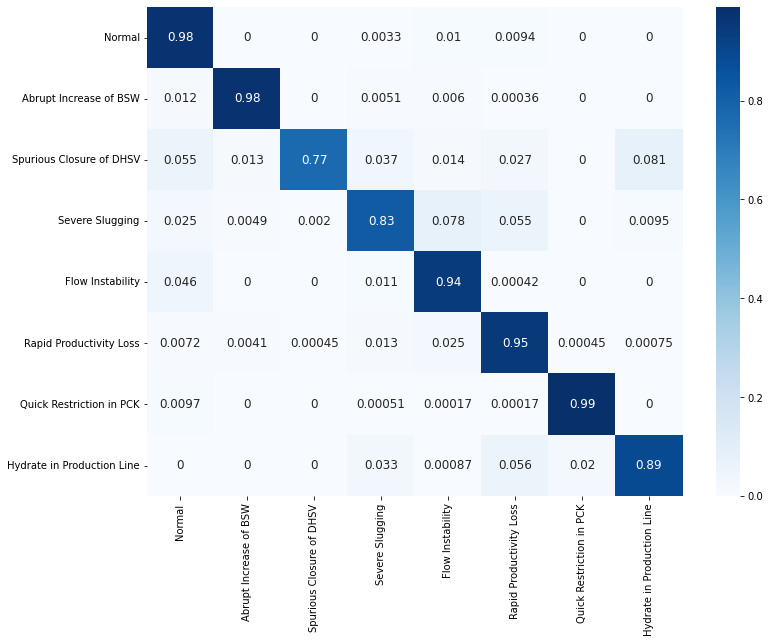

In [ ]:
y_pred = model_gs.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

arr = confusion_matrix(y_test, y_pred)
arr = arr.astype('float') / arr.sum(axis=1)[:, np.newaxis]

precision = []
recall = []
f1_arr = []
for i in range(8):
  suma_prec = 0
  suma_recall = 0
  for j in range(8):
    suma_prec += arr[j][i]
    suma_recall += arr[i][j]
  i_precision = arr[i][i] / suma_prec
  i_recall = arr[i][i] / suma_recall
  precision.append(i_precision)
  recall.append(i_recall)
  f1_arr.append((2 * i_precision * i_recall) / (i_precision + i_recall))


df_metrics = pd.DataFrame()
df_metrics['Class'] = [v for v in event_names.values()]
df_metrics['Precision'] = precision
df_metrics['Recall'] = recall
df_metrics['F1-score'] = f1_arr

display(df_metrics)

df_cm = pd.DataFrame(arr, [name for name in event_names.values()], [name for name in event_names.values()])
plt.figure(figsize=(12,9))
sb.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="Blues")

df = {'classifier': 'Decision Tree', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['ccp_alpha']}

results = results.append(df, ignore_index=True)



#### cross_val_score

In [ ]:
cv=cross_val_score(model_gs, X_test, y_test)
print(f"Cross value score: {cv}")

df_new={'classifier': 'Decision Tree', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['ccp_alpha']}
results_new=results_new.append(df_new, ignore_index=True)

#### Bagging

In [101]:
cv = 5

param_grid = [{'n_estimators': list(i for i in range(10, 13))}]

model = DecisionTreeClassifier()
bagging = BaggingClassifier(model, max_samples=0.5, max_features=0.5)

clf = GridSearchCV(bagging, param_grid, cv=5, scoring='f1_macro')
clf.fit(X_train, y_train)
model_gs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)


{'n_estimators': 12}
0.990667514529535


In [102]:
y_pred = model_gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)

In [104]:
cv=cross_val_score(model_gs, X_test, y_test)
print(f"Cross value score: {cv}")

df_bag={'classifier': 'Decision Tree', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['n_estimators']}
results_bag=results_bag.append(df_bag, ignore_index=True)

Cross value score: [0.99246547 0.99058183 0.99204605 0.99424385 0.99330194]


### Randomized search

In [105]:
cv = 5

param_grid = [{'ccp_alpha': list(math.exp(i) for i in range(-7, 0))}] 
model = DecisionTreeClassifier()

clf = RandomizedSearchCV(model, param_grid, cv=5, scoring='f1_macro')
clf.fit(X_train, y_train)
model_rs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


{'ccp_alpha': 0.0009118819655545162}
0.9542434037584488


#### f1_score

Accuracy: 0.9756996044121649
F1: 0.9566211367286297


,Class,Precision,Recall,F1-score
0,Normal,0.870677,0.988765,0.925971
1,Abrupt Increase of BSW,0.951272,0.985583,0.968124
2,Spurious Closure of DHSV,0.996804,0.772947,0.870717
3,Severe Slugging,0.954643,0.952671,0.953656
4,Flow Instability,0.970025,0.929229,0.949189
5,Rapid Productivity Loss,0.932561,0.981516,0.956412
6,Quick Restriction in PCK,1.000000,0.989413,0.994678
7,Hydrate in Production Line,0.916454,0.966942,0.941021


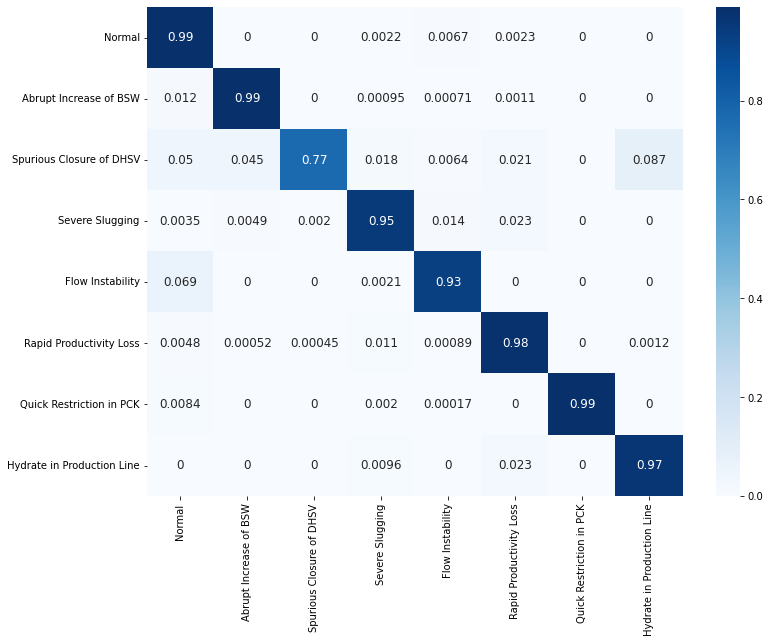

In [106]:
y_pred = model_rs.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

arr = confusion_matrix(y_test, y_pred)
arr = arr.astype('float') / arr.sum(axis=1)[:, np.newaxis]

precision = []
recall = []
f1_arr = []
for i in range(8):
  suma_prec = 0
  suma_recall = 0
  for j in range(8):
    suma_prec += arr[j][i]
    suma_recall += arr[i][j]
  i_precision = arr[i][i] / suma_prec
  i_recall = arr[i][i] / suma_recall
  precision.append(i_precision)
  recall.append(i_recall)
  f1_arr.append((2 * i_precision * i_recall) / (i_precision + i_recall))


df_metrics = pd.DataFrame()
df_metrics['Class'] = [v for v in event_names.values()]
df_metrics['Precision'] = precision
df_metrics['Recall'] = recall
df_metrics['F1-score'] = f1_arr

display(df_metrics)

df_cm = pd.DataFrame(arr, [name for name in event_names.values()], [name for name in event_names.values()])
plt.figure(figsize=(12,9))
sb.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="Blues")

df2 = {'classifier': 'Decision Tree', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['ccp_alpha']}

results = results.append(df2, ignore_index=True)



#### cross_val_score

In [107]:
cv=cross_val_score(model_rs, X_test, y_test)
print(f"Cross value score: {cv}")

df_new={'classifier': 'Decision Tree', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['ccp_alpha']}
results_new=results_new.append(df_new, ignore_index=True)

Cross value score: [0.97258267 0.97300126 0.97414966 0.97519623 0.97655678]


#### Bagging

In [ ]:
cv = 5

param_grid = [{'n_estimators': list(i for i in range(10, 13))}]

model = DecisionTreeClassifier()
bagging = BaggingClassifier(model, max_samples=0.5, max_features=0.5)

clf = RandomizedSearchCV(bagging, param_grid, cv=5, scoring='f1_macro')
clf.fit(X_train, y_train)
model_rs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)

In [ ]:
y_pred = model_rs.predict(X_test)
acc = accuracy_score(y_test, y_pred)

In [ ]:
cv=cross_val_score(model_rs, X_test, y_test)
print(f"Cross value score: {cv}")

df_rnd={'classifier': 'Decision Tree', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': clf.best_params_['ccp_alpha']}
results_rnd=results_rnd.append(df_rnd, ignore_index=True)

## Random Forest

### Grid search

In [ ]:
cv = 5
# za n_estimators dodani su 75 i 125
# za max_depth dodani su 1, 3 i 8
# za max_features dodani su 7 i 10

param_grid = [{'n_estimators': [50,75, 100, 125, 150, 175], 'max_depth': [1,3,5, 7, 8, 10, None], 'max_features': [5,7, int(math.sqrt(n_of_features)),10, 15]}]

model = RandomForestClassifier()

clf = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
clf.fit(X_train, y_train)
model_gs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)

In [ ]:
y_pred = model_gs.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

df = {'classifier': 'Random Forest', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': f"Max depth: {clf.best_params_['max_depth']}, max features: {clf.best_params_['max_features']}, num trees: {clf.best_params_['n_estimators']}"}

results = results.append(df, ignore_index=True)



In [ ]:
cv=cross_val_score(model, X_test, y_test)
print(f"Cross value score: {cv}")

df_new={'classifier': 'Random Forest', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': f"Max depth: {clf.best_params_['max_depth']}, max features: {clf.best_params_['max_features']}, num trees: {clf.best_params_['n_estimators']}"}
results_new=results_new.append(d_new, ignore_index=True)

### Randomized search

In [ ]:
cv = 5
# za n_estimators dodani su 75 i 125
# za max_depth dodani su 1, 3 i 8
# za max_features dodani su 7 i 10

param_grid = [{'n_estimators': [50,75, 100, 125, 150, 175], 'max_depth': [1,3,5, 7, 8, 10, None], 'max_features': [5,7, int(math.sqrt(n_of_features)),10, 15]}]


model = RandomForestClassifier()

clf = RandomizedSearchCV(model, param_grid, cv=5, scoring='f1_macro')
clf.fit(X_train, y_train)
model_rs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)

In [ ]:
y_pred = model_rs.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

df = {'classifier': 'Random Forest', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': f"Max depth: {clf.best_params_['max_depth']}, max features: {clf.best_params_['max_features']}, num trees: {clf.best_params_['n_estimators']}"}

results = results.append(df, ignore_index=True)



In [ ]:
cv=cross_val_score(model, X_test, y_test)
print(f"Cross value score: {cv}")

df_new={'classifier': 'Random Forest', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': f"Max depth: {clf.best_params_['max_depth']}, max features: {clf.best_params_['max_features']}, num trees: {clf.best_params_['n_estimators']}"}
results_new=results_new.append(d_new, ignore_index=True)

## AdaBoost

### Grid search

In [ ]:
cv = 5
# za n_estimators dodani su 150 i 475
# za max_depth dodani su 7 i 10
# za learning_rate dodani su 0.05 i 0.5

param_grid = [{'n_estimators': [100,150, 250, 400, 475, 550], 'max_depth': [1, 3, 5,7,10], 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]}]

model = AdaBoostClassifier()

clf = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
clf.fit(X_train, y_train)
model_gs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)

In [ ]:
y_pred = model_gs.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

df2 = {'classifier': 'AdaBoost', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': f"Max depth: {clf.best_params_['max_depth']}, num trees: {clf.best_params_['n_estimators']}, learning rate: {clf.best_params_['learning_rate']}"}

results = results.append(df2, ignore_index=True)

In [ ]:
cv=cross_val_score(model, X_test, y_test)
print(f"Cross value score: {cv}")

df_new2={'classifier': 'AdaBoost', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': f"Max depth: {clf.best_params_['max_depth']}, num trees: {clf.best_params_['n_estimators']}, learning rate: {clf.best_params_['learning_rate']}"}
results_new=results_new.append(d_new2, ignore_index=True)

### Randomized search

In [ ]:
cv = 5

# za n_estimators dodani su 150 i 475
# za max_depth dodani su 7 i 10
# za learning_rate dodani su 0.05 i 0.5

param_grid = [{'n_estimators': [100,150, 250, 400, 475, 550], 'max_depth': [1, 3, 5,7,10], 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]}]

model = AdaBoostClassifier()

clf = RandomizedSearchCV(model, param_grid, cv=5, scoring='f1_macro')
clf.fit(X_train, y_train)
model_rs = clf.best_estimator_

print(clf.best_params_)
print(clf.best_score_)

In [ ]:
y_pred = model_rs.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")

df = {'classifier': 'AdaBoost', 'f1': f1, 'accuracy': acc, 'time_window': 300, 'hiperparameters': f"Max depth: {clf.best_params_['max_depth']}, num trees: {clf.best_params_['n_estimators']}, learning rate: {clf.best_params_['learning_rate']}"}

results = results.append(df, ignore_index=True)

In [ ]:
cv=cross_val_score(model, X_test, y_test)
print(f"Cross value score: {cv}")

df_new={'classifier': 'AdaBoost', 'cross_val_score': cv, 'accuracy': acc, 'time_window': 300, 'hiperparameters': f"Max depth: {clf.best_params_['max_depth']}, num trees: {clf.best_params_['n_estimators']}, learning rate: {clf.best_params_['learning_rate']}"}
results_new=results_new.append(df_new, ignore_index=True)

Vrsta istraživanja provedena u članku prema:
  - svrsi: Primijenjeno istraživanje - istraživanje nepoželjnih događaja u radu naftnih bušotina u svrhu izrade modela koji može predvidjeti koji nepoželjan događaj se događa u danom trenutku na osnovu podataka očitanih sa senzora
  - izvoru informacija: Sekundarno istraživanje - korišten je ranije sastavljen skup podataka od strane drugih/e osoba/e
  - vremenu provedbe: Longitudinalno istraživanje - promatraju se vrijednosti dobivene od senzora u određenom vremenskom razdoblju
  - načinu prikupljanja: Dokumentarno istraživanje - sustavno su pregledane postojeće informacije i postojeći podaci o temi
  - vrsti korištenih podataka: Kvantitativno istraživanje - prikupljeni podaci su direktno očitani sa senzora pa tako skup podataka sadrži isključivo numeričke vrijednosti
  - stupnju manipulacije varijablama: Promatračko istraživanje - u članku su samo korišteni podaci koji su već postojali, ako gledamo same podatke, mogli bi reći da ima i elemenata kvazi-eksperimentalnog istraživanja jer su dodani mnogi simulirani podaci
  - dubini: elementi Objašnjavačkog i Korelacijskog istraživanja - cilj je definirati odnos između senzorskih varijabli i nepoželjnih događaja, ali i uspostavljanje uzročno-posljedičnih veza i pružanje dodatnih informacija o temi koju članak obrađuje
  - vrsti zaključka: Deduktivno istraživanje - samom izradom modela za klasifikaciju uvode se poveznice i zaključci o odnosu između ulaznih varijabli i događaja koji se predviđa

Način na koji su podaci za članak prikupljeni najviše nalikuje operacijskom istraživanju jer se promatraju događaji koji se stvarno događaju u radu naftnih bušotina.

Podaci su prikupljeni na etičan način. Nisam pronašao da je navedeno sa kojih je naftnih bušotina obavljeno prikupljanje podataka. To je dobro jer bi se u suprotnom možda moglo iskoristiti znanja iz članka za namjerno prouzročiti probleme da danoj naftnoj bušotini.
